In [13]:
#Data loader, cleaning and ready to feed
#Date feeder to the system
#Order Mgmt System

#Returns Analysis

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt





In [14]:
import pandas as pd
datapath = os.path.join('./DATA/eurusd_IndicatorDataMinute.csv')
datapath2 = os.path.join('./DATA/gbpusd_IndicatorDataMinute.csv')
df= pd.read_csv(datapath,  parse_dates=True, index_col=0, nrows = 10000)
df2= pd.read_csv(datapath2, parse_dates=True, index_col=0, nrows = 10000)

In [23]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
               
        dt = dt or (self.datas[0].datetime.datetime(0))
        print('%s, %s' % (dt.strftime('%Y/%m/%d %H:%M:%S'), txt))       

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.4f, Cost: %.4f, Comm %.4f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.4f, Cost: %.4f, Comm %.4f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

#         self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.4f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datas[0].close[-1] < self.datas[0].close[0]:
                    # current close less than previous close
#                 self.log('BUY CREATE, %.4f' % self.dataclose[0])
                self.log('self.datas[0].close[0] = {}'.format(self.datas[0].close[0]))
                self.log('self.datas[1].close[0] = {}'.format(self.datas[1].close[0]))
#                 self.log('HI close[0] = {}'.format(self.dataclose[0]))
#                 self.log('HI close[-1] = {}'.format(self.dataclose[-1]))

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(self.datas[0], size = 10000)

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.4f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(self.datas[0], size = 10000)


In [24]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
#     modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#     datapath = os.path.join(modpath, './orcl-1995-2014.txt')
#     datapath = os.path.join('./orcl-1995-2014.txt')
    datapath = os.path.join('./DATA/eurusd_IndicatorDataMinute.csv')

    # Create a Data Feed
#     data = bt.feeds.YahooFinanceCSVData(
#         dataname=datapath,
#         # Do not pass values before this date
#         fromdate=datetime.datetime(2013, 1, 1),
#         # Do not pass values before this date
#         todate=datetime.datetime(2013, 3, 31),
#         # Do not pass values after this date
#         reverse=False)
    
#     data2 = bt.feeds.GenericCSVData(
#                 dataname=datapath,
#                 datetime=0,
#                 fromdate=datetime.datetime(2018, 1, 1),
#                 todate=datetime.datetime(2018, 3, 31),
#                 sessionstart=datetime.time(0, 0), 
#                 sessionend=datetime.time(23, 59),
#                 timeframe=bt.TimeFrame.Minutes,
#                 compression=5,
#                 dtformat=('%m/%d/%Y %H:%M:%S %p'),
#                 open=1,
#                 high=2,
#                 low=3,
#                 close=4,
#                 volume=5,
#                 time=-1,
#                 openinterest=-1)
    
    data3 = bt.feeds.PandasData(dataname=df,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=5)
    data3b = bt.feeds.PandasData(dataname=df2,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=5)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data3)
    cerebro.adddata(data3b)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
#     cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Minutes, compression=5, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Minutes, compression=5, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='mysqn')
    
    # Run over everything
    strategies = cerebro.run()
    
    thestrat = strategies[0]

    print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
    print('SQN:', thestrat.analyzers.mysqn.get_analysis())
    
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    

Starting Portfolio Value: 100000.00
2008/05/04 18:10:00, self.datas[0].close[0] = 1.5433
2008/05/04 18:10:00, self.datas[1].close[0] = 1.9732
2008/05/04 18:15:00, BUY EXECUTED, Price: 1.5434, Cost: 15434.0000, Comm 15.4340
2008/05/04 18:40:00, SELL CREATE, 1.5427
2008/05/04 18:50:00, SELL EXECUTED, Price: 1.5428, Cost: 15434.0000, Comm 15.4280
2008/05/04 18:50:00, self.datas[0].close[0] = 1.5428
2008/05/04 18:50:00, self.datas[1].close[0] = 1.9729
2008/05/04 18:55:00, BUY EXECUTED, Price: 1.5430, Cost: 15430.0000, Comm 15.4300
2008/05/04 19:20:00, SELL CREATE, 1.5435
2008/05/04 19:35:00, SELL EXECUTED, Price: 1.5434, Cost: 15430.0000, Comm 15.4340
2008/05/04 19:45:00, self.datas[0].close[0] = 1.5434
2008/05/04 19:45:00, self.datas[1].close[0] = 1.9738
2008/05/04 19:50:00, BUY EXECUTED, Price: 1.5435, Cost: 15435.0000, Comm 15.4350
2008/05/04 20:15:00, SELL CREATE, 1.5446
2008/05/04 20:20:00, SELL EXECUTED, Price: 1.5447, Cost: 15435.0000, Comm 15.4470
2008/05/04 20:20:00, self.datas[0]

2008/05/07 17:15:00, BUY EXECUTED, Price: 1.5393, Cost: 15393.0000, Comm 15.3930
2008/05/07 17:45:00, SELL CREATE, 1.5394
2008/05/07 17:50:00, SELL EXECUTED, Price: 1.5393, Cost: 15393.0000, Comm 15.3930
2008/05/07 17:55:00, self.datas[0].close[0] = 1.5394
2008/05/07 17:55:00, self.datas[1].close[0] = 1.9539
2008/05/07 18:00:00, BUY EXECUTED, Price: 1.5396, Cost: 15396.0000, Comm 15.3960
2008/05/07 18:25:00, SELL CREATE, 1.5402
2008/05/07 18:35:00, SELL EXECUTED, Price: 1.5401, Cost: 15396.0000, Comm 15.4010
2008/05/07 18:55:00, self.datas[0].close[0] = 1.5386
2008/05/07 18:55:00, self.datas[1].close[0] = 1.9527
2008/05/07 19:00:00, BUY EXECUTED, Price: 1.5385, Cost: 15385.0000, Comm 15.3850
2008/05/07 19:25:00, SELL CREATE, 1.5372
2008/05/07 19:30:00, SELL EXECUTED, Price: 1.5376, Cost: 15385.0000, Comm 15.3760
2008/05/07 19:45:00, self.datas[0].close[0] = 1.5364799999999998
2008/05/07 19:45:00, self.datas[1].close[0] = 1.9513
2008/05/07 19:50:00, BUY EXECUTED, Price: 1.5361, Cost: 15

2008/05/12 18:05:00, BUY EXECUTED, Price: 1.5541, Cost: 15541.0000, Comm 15.5410
2008/05/12 18:30:00, SELL CREATE, 1.5540
2008/05/12 18:45:00, SELL EXECUTED, Price: 1.5535, Cost: 15541.0000, Comm 15.5350
2008/05/12 18:55:00, self.datas[0].close[0] = 1.5539
2008/05/12 18:55:00, self.datas[1].close[0] = 1.9568
2008/05/12 19:05:00, BUY EXECUTED, Price: 1.5533, Cost: 15533.0000, Comm 15.5330
2008/05/12 19:30:00, SELL CREATE, 1.5530
2008/05/12 19:35:00, SELL EXECUTED, Price: 1.5527, Cost: 15533.0000, Comm 15.5270
2008/05/12 19:50:00, self.datas[0].close[0] = 1.5526
2008/05/12 19:50:00, self.datas[1].close[0] = 1.9526
2008/05/12 19:55:00, BUY EXECUTED, Price: 1.5524, Cost: 15524.0000, Comm 15.5240
2008/05/12 20:25:00, SELL CREATE, 1.5540
2008/05/12 20:35:00, SELL EXECUTED, Price: 1.5537, Cost: 15524.0000, Comm 15.5370
2008/05/12 21:15:00, self.datas[0].close[0] = 1.5516
2008/05/12 21:15:00, self.datas[1].close[0] = 1.9528
2008/05/12 21:20:00, BUY EXECUTED, Price: 1.5516, Cost: 15515.7000, Co

2008/05/15 01:55:00, SELL CREATE, 1.5498
2008/05/15 02:00:00, SELL EXECUTED, Price: 1.5497, Cost: 15483.0000, Comm 15.4970
2008/05/15 02:05:00, self.datas[0].close[0] = 1.5511
2008/05/15 02:05:00, self.datas[1].close[0] = 1.9469999999999998
2008/05/15 02:10:00, BUY EXECUTED, Price: 1.5509, Cost: 15509.0000, Comm 15.5090
2008/05/15 02:35:00, SELL CREATE, 1.5536
2008/05/15 02:40:00, SELL EXECUTED, Price: 1.5535, Cost: 15509.0000, Comm 15.5350
2008/05/15 02:45:00, self.datas[0].close[0] = 1.5531
2008/05/15 02:45:00, self.datas[1].close[0] = 1.94707
2008/05/15 02:50:00, BUY EXECUTED, Price: 1.5530, Cost: 15530.2000, Comm 15.5302
2008/05/15 03:15:00, SELL CREATE, 1.5537
2008/05/15 03:20:00, SELL EXECUTED, Price: 1.5534, Cost: 15530.2000, Comm 15.5340
2008/05/15 03:25:00, self.datas[0].close[0] = 1.5535
2008/05/15 03:25:00, self.datas[1].close[0] = 1.9465
2008/05/15 03:40:00, BUY EXECUTED, Price: 1.5536, Cost: 15536.0000, Comm 15.5360
2008/05/15 04:05:00, SELL CREATE, 1.5525
2008/05/15 04:10

2008/05/19 11:30:00, BUY EXECUTED, Price: 1.5499, Cost: 15499.0000, Comm 15.4990
2008/05/19 11:55:00, SELL CREATE, 1.5511
2008/05/19 12:00:00, SELL EXECUTED, Price: 1.5515, Cost: 15499.0000, Comm 15.5150
2008/05/19 12:00:00, self.datas[0].close[0] = 1.5515
2008/05/19 12:00:00, self.datas[1].close[0] = 1.9472
2008/05/19 12:05:00, BUY EXECUTED, Price: 1.5516, Cost: 15516.0000, Comm 15.5160
2008/05/19 12:30:00, SELL CREATE, 1.5513
2008/05/19 12:35:00, SELL EXECUTED, Price: 1.5512, Cost: 15516.0000, Comm 15.5120
2008/05/19 12:40:00, self.datas[0].close[0] = 1.5507
2008/05/19 12:40:00, self.datas[1].close[0] = 1.9467
2008/05/19 12:45:00, BUY EXECUTED, Price: 1.5514, Cost: 15514.0000, Comm 15.5140
2008/05/19 13:10:00, SELL CREATE, 1.5508
2008/05/19 13:15:00, SELL EXECUTED, Price: 1.5507, Cost: 15514.0000, Comm 15.5069
2008/05/19 13:35:00, self.datas[0].close[0] = 1.5502
2008/05/19 13:35:00, self.datas[1].close[0] = 1.9469999999999998
2008/05/19 13:40:00, BUY EXECUTED, Price: 1.5503, Cost: 15

2008/05/22 03:05:00, BUY EXECUTED, Price: 1.5803, Cost: 15803.0000, Comm 15.8030
2008/05/22 03:30:00, SELL CREATE, 1.5783
2008/05/22 03:35:00, SELL EXECUTED, Price: 1.5782, Cost: 15803.0000, Comm 15.7823
2008/05/22 03:35:00, self.datas[0].close[0] = 1.5786
2008/05/22 03:35:00, self.datas[1].close[0] = 1.974
2008/05/22 03:40:00, BUY EXECUTED, Price: 1.5785, Cost: 15784.6000, Comm 15.7846
2008/05/22 04:05:00, SELL CREATE, 1.5763
2008/05/22 04:10:00, SELL EXECUTED, Price: 1.5764, Cost: 15784.6000, Comm 15.7640
2008/05/22 04:10:00, self.datas[0].close[0] = 1.5764
2008/05/22 04:10:00, self.datas[1].close[0] = 1.9729
2008/05/22 04:15:00, BUY EXECUTED, Price: 1.5761, Cost: 15760.6000, Comm 15.7606
2008/05/22 04:40:00, SELL CREATE, 1.5752
2008/05/22 04:45:00, SELL EXECUTED, Price: 1.5753, Cost: 15760.6000, Comm 15.7530
2008/05/22 04:45:00, self.datas[0].close[0] = 1.5756
2008/05/22 04:45:00, self.datas[1].close[0] = 1.9762
2008/05/22 04:50:00, BUY EXECUTED, Price: 1.5752, Cost: 15752.0000, Com

2008/05/27 01:00:00, SELL CREATE, 1.5792
2008/05/27 01:15:00, SELL EXECUTED, Price: 1.5790, Cost: 15795.0000, Comm 15.7900
2008/05/27 01:20:00, self.datas[0].close[0] = 1.5793
2008/05/27 01:20:00, self.datas[1].close[0] = 1.9818
2008/05/27 01:25:00, BUY EXECUTED, Price: 1.5794, Cost: 15794.0000, Comm 15.7940
2008/05/27 01:50:00, SELL CREATE, 1.5817
2008/05/27 01:55:00, SELL EXECUTED, Price: 1.5814, Cost: 15794.0000, Comm 15.8140
2008/05/27 02:00:00, self.datas[0].close[0] = 1.5816
2008/05/27 02:00:00, self.datas[1].close[0] = 1.984
2008/05/27 02:05:00, BUY EXECUTED, Price: 1.5815, Cost: 15815.0000, Comm 15.8150
2008/05/27 02:30:00, SELL CREATE, 1.5762
2008/05/27 02:35:00, SELL EXECUTED, Price: 1.5764, Cost: 15815.0000, Comm 15.7640
2008/05/27 02:35:00, self.datas[0].close[0] = 1.5765
2008/05/27 02:35:00, self.datas[1].close[0] = 1.9783
2008/05/27 02:40:00, BUY EXECUTED, Price: 1.5768, Cost: 15768.0000, Comm 15.7680
2008/05/27 03:05:00, SELL CREATE, 1.5747
2008/05/27 03:10:00, SELL EXEC

2008/05/29 08:20:00, self.datas[0].close[0] = 1.5561
2008/05/29 08:20:00, self.datas[1].close[0] = 1.9774
2008/05/29 08:25:00, BUY EXECUTED, Price: 1.5557, Cost: 15557.0000, Comm 15.5570
2008/05/29 08:50:00, SELL CREATE, 1.5577
2008/05/29 08:55:00, SELL EXECUTED, Price: 1.5572, Cost: 15557.0000, Comm 15.5720
2008/05/29 09:20:00, self.datas[0].close[0] = 1.5539
2008/05/29 09:20:00, self.datas[1].close[0] = 1.9765
2008/05/29 09:25:00, BUY EXECUTED, Price: 1.5540, Cost: 15540.0000, Comm 15.5400
2008/05/29 11:05:00, SELL CREATE, 1.5535
2008/05/29 11:10:00, SELL EXECUTED, Price: 1.5539, Cost: 15540.0000, Comm 15.5390
2008/05/29 11:45:00, self.datas[0].close[0] = 1.5527
2008/05/29 11:45:00, self.datas[1].close[0] = 1.9755
2008/05/29 11:50:00, BUY EXECUTED, Price: 1.5529, Cost: 15529.0000, Comm 15.5290
2008/05/29 12:15:00, SELL CREATE, 1.5505
2008/05/29 12:20:00, SELL EXECUTED, Price: 1.5504, Cost: 15529.0000, Comm 15.5041
2008/05/29 12:25:00, self.datas[0].close[0] = 1.55064
2008/05/29 12:25

2008/05/30 14:50:00, BUY EXECUTED, Price: 1.5554, Cost: 15554.0000, Comm 15.5540
2008/05/30 15:15:00, SELL CREATE, 1.5555
2008/05/30 15:35:00, SELL EXECUTED, Price: 1.5556, Cost: 15554.0000, Comm 15.5560
2008/05/30 15:35:00, self.datas[0].close[0] = 1.5556
2008/05/30 15:35:00, self.datas[1].close[0] = 1.9805
2008/05/30 15:45:00, BUY EXECUTED, Price: 1.5558, Cost: 15558.0000, Comm 15.5580
2008/05/30 16:10:00, SELL CREATE, 1.5552
2008/05/30 16:30:00, SELL EXECUTED, Price: 1.5553, Cost: 15558.0000, Comm 15.5530
2008/05/30 16:30:00, self.datas[0].close[0] = 1.5556
2008/05/30 16:30:00, self.datas[1].close[0] = 1.9819
2008/05/30 16:40:00, BUY EXECUTED, Price: 1.5555, Cost: 15555.0000, Comm 15.5550
2008/06/01 17:10:00, SELL CREATE, 1.5569
2008/06/01 17:15:00, SELL EXECUTED, Price: 1.5566, Cost: 15555.0000, Comm 15.5660
2008/06/01 18:00:00, self.datas[0].close[0] = 1.556
2008/06/01 18:00:00, self.datas[1].close[0] = 1.9769999999999999
2008/06/01 18:05:00, BUY EXECUTED, Price: 1.5561, Cost: 155

2008/06/04 03:30:00, SELL CREATE, 1.5438
2008/06/04 03:35:00, SELL EXECUTED, Price: 1.5436, Cost: 15447.0000, Comm 15.4360
2008/06/04 03:35:00, self.datas[0].close[0] = 1.5444
2008/06/04 03:35:00, self.datas[1].close[0] = 1.9564
2008/06/04 03:40:00, BUY EXECUTED, Price: 1.5445, Cost: 15445.0000, Comm 15.4450
2008/06/04 04:05:00, SELL CREATE, 1.5437
2008/06/04 04:10:00, SELL EXECUTED, Price: 1.5439, Cost: 15445.0000, Comm 15.4390
2008/06/04 04:10:00, self.datas[0].close[0] = 1.5441
2008/06/04 04:10:00, self.datas[1].close[0] = 1.9556
2008/06/04 04:15:00, BUY EXECUTED, Price: 1.5445, Cost: 15445.0000, Comm 15.4450
2008/06/04 04:40:00, SELL CREATE, 1.5468
2008/06/04 04:45:00, SELL EXECUTED, Price: 1.5464, Cost: 15445.0000, Comm 15.4640
2008/06/04 04:50:00, self.datas[0].close[0] = 1.5476
2008/06/04 04:50:00, self.datas[1].close[0] = 1.9564
2008/06/04 04:55:00, BUY EXECUTED, Price: 1.5475, Cost: 15475.3000, Comm 15.4753
2008/06/04 05:20:00, SELL CREATE, 1.5452
2008/06/04 05:25:00, SELL EXE

2008/06/06 09:55:00, BUY EXECUTED, Price: 1.5682, Cost: 15682.0000, Comm 15.6820
2008/06/06 10:20:00, SELL CREATE, 1.5702
2008/06/06 10:25:00, SELL EXECUTED, Price: 1.5701, Cost: 15682.0000, Comm 15.7006
2008/06/06 10:35:00, self.datas[0].close[0] = 1.5696
2008/06/06 10:35:00, self.datas[1].close[0] = 1.965
2008/06/06 10:40:00, BUY EXECUTED, Price: 1.5697, Cost: 15697.0000, Comm 15.6970
2008/06/06 11:05:00, SELL CREATE, 1.5741
2008/06/06 11:10:00, SELL EXECUTED, Price: 1.5744, Cost: 15697.0000, Comm 15.7440
2008/06/06 11:10:00, self.datas[0].close[0] = 1.5742
2008/06/06 11:10:00, self.datas[1].close[0] = 1.9728
2008/06/06 11:15:00, BUY EXECUTED, Price: 1.5741, Cost: 15741.0000, Comm 15.7410
2008/06/06 11:40:00, SELL CREATE, 1.5738
2008/06/06 11:45:00, SELL EXECUTED, Price: 1.5741, Cost: 15741.0000, Comm 15.7410
2008/06/06 12:00:00, self.datas[0].close[0] = 1.5730000000000002
2008/06/06 12:00:00, self.datas[1].close[0] = 1.96953
2008/06/06 12:05:00, BUY EXECUTED, Price: 1.5727, Cost: 15

2008/06/10 14:25:00, BUY EXECUTED, Price: 1.5454, Cost: 15454.0000, Comm 15.4540
2008/06/10 14:50:00, SELL CREATE, 1.5443
2008/06/10 14:55:00, SELL EXECUTED, Price: 1.5446, Cost: 15454.0000, Comm 15.4460
2008/06/10 14:55:00, self.datas[0].close[0] = 1.5447
2008/06/10 14:55:00, self.datas[1].close[0] = 1.9532
2008/06/10 15:00:00, BUY EXECUTED, Price: 1.5449, Cost: 15449.0000, Comm 15.4490
2008/06/10 15:15:00, SELL CREATE, 1.5460
2008/06/10 15:35:00, SELL EXECUTED, Price: 1.5458, Cost: 15449.0000, Comm 15.4582
2008/06/10 15:40:00, self.datas[0].close[0] = 1.5459
2008/06/10 15:40:00, self.datas[1].close[0] = 1.9539
2008/06/10 15:45:00, BUY EXECUTED, Price: 1.5460, Cost: 15460.0000, Comm 15.4600
2008/06/10 16:10:00, SELL CREATE, 1.5456
2008/06/10 16:15:00, SELL EXECUTED, Price: 1.5457, Cost: 15460.0000, Comm 15.4570
2008/06/10 16:15:00, self.datas[0].close[0] = 1.5458
2008/06/10 16:15:00, self.datas[1].close[0] = 1.9542599999999999
2008/06/10 16:20:00, BUY EXECUTED, Price: 1.5459, Cost: 15

2008/06/12 21:45:00, SELL CREATE, 1.5460
2008/06/12 21:55:00, SELL EXECUTED, Price: 1.5456, Cost: 15443.0000, Comm 15.4560
2008/06/12 22:10:00, self.datas[0].close[0] = 1.5453
2008/06/12 22:10:00, self.datas[1].close[0] = 1.9482
2008/06/12 22:20:00, BUY EXECUTED, Price: 1.5454, Cost: 15454.0000, Comm 15.4540
2008/06/12 22:40:00, SELL CREATE, 1.5454
2008/06/12 22:50:00, SELL EXECUTED, Price: 1.5452, Cost: 15454.0000, Comm 15.4520
2008/06/12 22:55:00, self.datas[0].close[0] = 1.5456
2008/06/12 22:55:00, self.datas[1].close[0] = 1.9483
2008/06/12 23:00:00, BUY EXECUTED, Price: 1.5452, Cost: 15452.3000, Comm 15.4523
2008/06/12 23:25:00, SELL CREATE, 1.5456
2008/06/12 23:40:00, SELL EXECUTED, Price: 1.5457, Cost: 15452.3000, Comm 15.4570
2008/06/12 23:40:00, self.datas[0].close[0] = 1.5458
2008/06/12 23:40:00, self.datas[1].close[0] = 1.9488
2008/06/12 23:45:00, BUY EXECUTED, Price: 1.5459, Cost: 15459.0000, Comm 15.4590
2008/06/13 00:10:00, SELL CREATE, 1.5442
2008/06/13 00:15:00, SELL EXE

2008/06/17 05:50:00, SELL CREATE, 1.5503
2008/06/17 05:55:00, SELL EXECUTED, Price: 1.5503, Cost: 15490.0000, Comm 15.5030
2008/06/17 06:15:00, self.datas[0].close[0] = 1.5492
2008/06/17 06:15:00, self.datas[1].close[0] = 1.9521
2008/06/17 06:20:00, BUY EXECUTED, Price: 1.5494, Cost: 15494.0000, Comm 15.4940
2008/06/17 06:45:00, SELL CREATE, 1.5501
2008/06/17 06:50:00, SELL EXECUTED, Price: 1.5499, Cost: 15494.0000, Comm 15.4990
2008/06/17 06:55:00, self.datas[0].close[0] = 1.5503
2008/06/17 06:55:00, self.datas[1].close[0] = 1.9508
2008/06/17 07:00:00, BUY EXECUTED, Price: 1.5502, Cost: 15502.0000, Comm 15.5020
2008/06/17 07:25:00, SELL CREATE, 1.5488
2008/06/17 07:35:00, SELL EXECUTED, Price: 1.5486, Cost: 15502.0000, Comm 15.4860
2008/06/17 07:45:00, self.datas[0].close[0] = 1.5489
2008/06/17 07:45:00, self.datas[1].close[0] = 1.9478
2008/06/17 07:50:00, BUY EXECUTED, Price: 1.5494, Cost: 15494.0000, Comm 15.4940
2008/06/17 08:15:00, SELL CREATE, 1.5479
2008/06/17 08:20:00, SELL EXE

2008/06/19 06:35:00, SELL CREATE, 1.5492
2008/06/19 06:40:00, SELL EXECUTED, Price: 1.5493, Cost: 15486.0000, Comm 15.4930
2008/06/19 06:40:00, self.datas[0].close[0] = 1.5494
2008/06/19 06:40:00, self.datas[1].close[0] = 1.9686
2008/06/19 06:45:00, BUY EXECUTED, Price: 1.5492, Cost: 15492.0000, Comm 15.4920
2008/06/19 07:10:00, SELL CREATE, 1.5487
2008/06/19 07:20:00, SELL EXECUTED, Price: 1.5489, Cost: 15492.0000, Comm 15.4890
2008/06/19 07:20:00, self.datas[0].close[0] = 1.5489
2008/06/19 07:20:00, self.datas[1].close[0] = 1.9695
2008/06/19 07:25:00, BUY EXECUTED, Price: 1.5492, Cost: 15492.0000, Comm 15.4920
2008/06/19 07:50:00, SELL CREATE, 1.5482
2008/06/19 07:55:00, SELL EXECUTED, Price: 1.5480, Cost: 15492.0000, Comm 15.4800
2008/06/19 08:10:00, self.datas[0].close[0] = 1.5476
2008/06/19 08:10:00, self.datas[1].close[0] = 1.9688
2008/06/19 08:15:00, BUY EXECUTED, Price: 1.5478, Cost: 15478.0000, Comm 15.4780
2008/06/19 08:40:00, SELL CREATE, 1.5480
2008/06/19 08:45:00, SELL EXE

2008/06/23 05:10:00, BUY EXECUTED, Price: 1.5524, Cost: 15524.0000, Comm 15.5240
2008/06/23 05:30:00, SELL CREATE, 1.5534
2008/06/23 05:40:00, SELL EXECUTED, Price: 1.5532, Cost: 15524.0000, Comm 15.5320
2008/06/23 05:45:00, self.datas[0].close[0] = 1.5532
2008/06/23 05:45:00, self.datas[1].close[0] = 1.9661
2008/06/23 05:50:00, BUY EXECUTED, Price: 1.5531, Cost: 15530.9000, Comm 15.5309
2008/06/23 06:15:00, SELL CREATE, 1.5522
2008/06/23 06:20:00, SELL EXECUTED, Price: 1.5521, Cost: 15530.9000, Comm 15.5210
2008/06/23 06:25:00, self.datas[0].close[0] = 1.5523
2008/06/23 06:25:00, self.datas[1].close[0] = 1.9644
2008/06/23 06:30:00, BUY EXECUTED, Price: 1.5529, Cost: 15529.0000, Comm 15.5290
2008/06/23 06:55:00, SELL CREATE, 1.5525
2008/06/23 07:00:00, SELL EXECUTED, Price: 1.5525, Cost: 15529.0000, Comm 15.5249
2008/06/23 07:20:00, self.datas[0].close[0] = 1.5519100000000001
2008/06/23 07:20:00, self.datas[1].close[0] = 1.9617
2008/06/23 07:25:00, BUY EXECUTED, Price: 1.5519, Cost: 15

2008/06/25 12:30:00, self.datas[1].close[0] = 1.9669999999999999
2008/06/25 12:35:00, BUY EXECUTED, Price: 1.5572, Cost: 15572.0000, Comm 15.5720
2008/06/25 13:05:00, SELL CREATE, 1.5573
2008/06/25 13:15:00, SELL EXECUTED, Price: 1.5574, Cost: 15572.0000, Comm 15.5740
2008/06/25 13:15:00, self.datas[0].close[0] = 1.5574
2008/06/25 13:15:00, self.datas[1].close[0] = 1.9679
2008/06/25 13:20:00, BUY EXECUTED, Price: 1.5573, Cost: 15573.0000, Comm 15.5730
2008/06/25 13:50:00, SELL CREATE, 1.5578
2008/06/25 14:00:00, SELL EXECUTED, Price: 1.5579, Cost: 15573.0000, Comm 15.5790
2008/06/25 14:00:00, self.datas[0].close[0] = 1.5587
2008/06/25 14:00:00, self.datas[1].close[0] = 1.9686
2008/06/25 14:05:00, BUY EXECUTED, Price: 1.5587, Cost: 15586.9000, Comm 15.5869
2008/06/25 14:30:00, SELL CREATE, 1.5648
2008/06/25 14:35:00, SELL EXECUTED, Price: 1.5647, Cost: 15586.9000, Comm 15.6470
2008/06/25 14:45:00, self.datas[0].close[0] = 1.56751
2008/06/25 14:45:00, self.datas[1].close[0] = 1.9734
2008

2008/06/27 11:50:00, BUY EXECUTED, Price: 1.5753, Cost: 15753.0000, Comm 15.7530
2008/06/27 12:15:00, SELL CREATE, 1.5750
2008/06/27 12:20:00, SELL EXECUTED, Price: 1.5748, Cost: 15753.0000, Comm 15.7480
2008/06/27 12:30:00, self.datas[0].close[0] = 1.5749
2008/06/27 12:30:00, self.datas[1].close[0] = 1.9936
2008/06/27 12:35:00, BUY EXECUTED, Price: 1.5750, Cost: 15750.0000, Comm 15.7500
2008/06/27 13:00:00, SELL CREATE, 1.5753
2008/06/27 13:05:00, SELL EXECUTED, Price: 1.5754, Cost: 15750.0000, Comm 15.7540
2008/06/27 13:05:00, self.datas[0].close[0] = 1.5763
2008/06/27 13:05:00, self.datas[1].close[0] = 1.9938
2008/06/27 13:10:00, BUY EXECUTED, Price: 1.5766, Cost: 15766.0000, Comm 15.7660
2008/06/27 13:35:00, SELL CREATE, 1.5777
2008/06/27 13:40:00, SELL EXECUTED, Price: 1.5778, Cost: 15766.0000, Comm 15.7780
2008/06/27 13:40:00, self.datas[0].close[0] = 1.5779
2008/06/27 13:40:00, self.datas[1].close[0] = 1.9944
2008/06/27 13:45:00, BUY EXECUTED, Price: 1.5782, Cost: 15782.0000, Co

2008/06/30 18:10:00, BUY EXECUTED, Price: 1.5757, Cost: 15757.0000, Comm 15.7570
2008/06/30 18:35:00, SELL CREATE, 1.5757
2008/06/30 18:40:00, SELL EXECUTED, Price: 1.5758, Cost: 15757.0000, Comm 15.7580
2008/06/30 18:40:00, self.datas[0].close[0] = 1.5758
2008/06/30 18:40:00, self.datas[1].close[0] = 1.9931
2008/06/30 18:45:00, BUY EXECUTED, Price: 1.5757, Cost: 15757.0000, Comm 15.7570
2008/06/30 19:10:00, SELL CREATE, 1.5755
2008/06/30 19:15:00, SELL EXECUTED, Price: 1.5754, Cost: 15757.0000, Comm 15.7540
2008/06/30 19:15:00, self.datas[0].close[0] = 1.5759
2008/06/30 19:15:00, self.datas[1].close[0] = 1.9929
2008/06/30 19:20:00, BUY EXECUTED, Price: 1.5758, Cost: 15758.0000, Comm 15.7580
2008/06/30 19:45:00, SELL CREATE, 1.5756
2008/06/30 19:50:00, SELL EXECUTED, Price: 1.5755, Cost: 15758.0000, Comm 15.7550
2008/06/30 19:55:00, self.datas[0].close[0] = 1.5759
2008/06/30 19:55:00, self.datas[1].close[0] = 1.9931
2008/06/30 20:00:00, BUY EXECUTED, Price: 1.5760, Cost: 15760.0000, Co

2008/07/02 07:10:00, SELL CREATE, 1.5792
2008/07/02 07:15:00, SELL EXECUTED, Price: 1.5791, Cost: 15784.0000, Comm 15.7910
2008/07/02 07:20:00, self.datas[0].close[0] = 1.5791
2008/07/02 07:20:00, self.datas[1].close[0] = 1.9858
2008/07/02 07:25:00, BUY EXECUTED, Price: 1.5792, Cost: 15792.0000, Comm 15.7920
2008/07/02 07:50:00, SELL CREATE, 1.5806
2008/07/02 07:55:00, SELL EXECUTED, Price: 1.5807, Cost: 15792.0000, Comm 15.8070
2008/07/02 07:55:00, self.datas[0].close[0] = 1.5808
2008/07/02 07:55:00, self.datas[1].close[0] = 1.9871
2008/07/02 08:00:00, BUY EXECUTED, Price: 1.5807, Cost: 15807.0000, Comm 15.8070
2008/07/02 08:25:00, SELL CREATE, 1.5836
2008/07/02 08:30:00, SELL EXECUTED, Price: 1.5837, Cost: 15807.0000, Comm 15.8370
2008/07/02 08:35:00, self.datas[0].close[0] = 1.5833
2008/07/02 08:35:00, self.datas[1].close[0] = 1.9899
2008/07/02 08:40:00, BUY EXECUTED, Price: 1.5832, Cost: 15832.0000, Comm 15.8320
2008/07/02 09:05:00, SELL CREATE, 1.5862
2008/07/02 09:10:00, SELL EXE

<IPython.core.display.Javascript object>


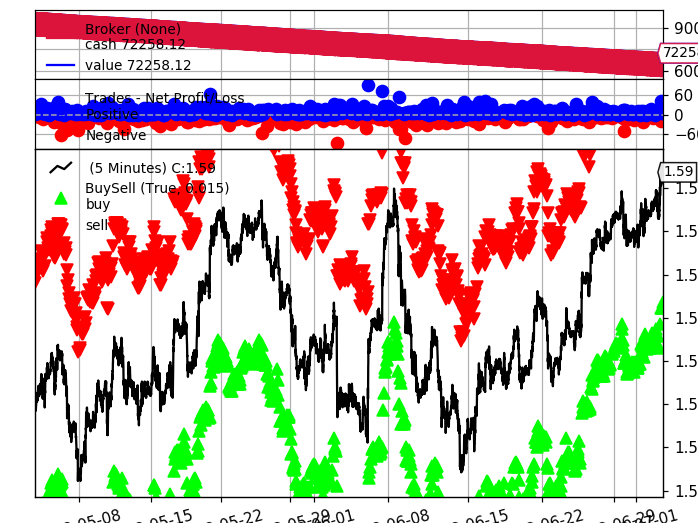

[[<Figure size 640x480 with 4 Axes>]]

In [5]:
cerebro.plot()